# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: Monday, March 21, 11:59pm**


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", 0)

#Added:
from sklearn.metrics.pairwise import cosine_distances
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.impute import KNNImputer

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note 2: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/abhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "mango_fruit",
    "pastry",
    "Julia language",
    "Python language",
    "hockey",
    "football",
    "supervised learning",
    "unsupervised learning"    
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,mango_fruit,"A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.",33
1,pastry,"Pastry is a dough of flour, water and shortening (solid fats, including butter or lard) that may be savoury or sweetened.",26
2,Julia language,"Julia is a high-level, high-performance, dynamic programming language.",11
3,Python language,"Python is a high-level, general-purpose programming language.",9
4,hockey,"Hockey is a term used to denote various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",37
5,football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22
6,supervised learning,Supervised learning (SL) is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.,27
7,unsupervised learning,Unsupervised learning is a type of algorithm that learns patterns from untagged data.,14


I would expect these queries to be classified based on their similarities. Depending on the clustering algortihm and parameters given such as n_clusters, the amount clusters it evaluates to can vary. If I were to manually clustered, there are many possibilities, but one such example: cluster of Food (mango_fruit, pastry), Programming languages (Julia language, Python language), sports (hockey, football), and machine learning types (supervised learning, unsupervised learning). Thus, I would have 4 clusters.

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:4}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from 1.1 with [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in 1.1.  
2. Examine clustering labels assigned by `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names(), index=wiki_df.index
)
bow_df

/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,algorithm,ball,bangladesh,based,believed,butter,data,degrees,denote,dough,...,tropical,type,types,unsupervised,untagged,used,various,varying,water,winter
0,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
5,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,0,0


In [5]:
print(bow_sents)
kmeans = KMeans(n_clusters=4)
kmeans.fit(bow_sents)

predictedClustersKBow = kmeans.predict(bow_sents)
print(predictedClustersKBow)

[[0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
  0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 1
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1
  1 0 0 0 1 0 0 1 1 0 0 1]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Predictions by K-means:
    Cluster 0: supervised learning
    Cluster 1: pastry, Julia language, Python language, football, unsupervised learning
    Cluster 2: mango_fruit
    Cluster 3: hockey

K-means is doing a very poor job at clustering these queries, for example pastry and unsupervised learning are clustered together even though they don't share any obvious similarities.
The algorithm missed obvious similarities such as (supervised learning and unsupervised learning) OR (Julia language, Python language) and others as predicted in Exercise 1.1 above.
This is likely because K-Means highly relies on the placement of the random clustered centres and due to this randomness, the results didn't align well in this case. Not to mention the bag of words data it is working with only provides the count of every word in that query, therefore missing any contextual information to make a good clustering assignment.

<br><br>

### 1.3 Sentence embedding representation
rubric={points:6}

Clustering is sensitive to what kind of representation we use for the given data. 
Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this exercise. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [6]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [7]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

Ignored unknown kwarg option direction


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.056666,-0.025778,0.248908,-0.052198,-0.046876,0.202116,0.235076,0.322160,-0.023798,0.133034,...,0.239582,-0.022871,0.071445,0.402666,-0.134781,0.177697,-0.123652,0.446758,0.204768,-0.048541
1,-0.062657,0.214339,-0.025160,0.276730,0.401149,0.030865,-0.089944,0.331922,-0.247056,0.175028,...,0.039294,-0.100197,0.201216,0.257111,0.194594,0.280075,0.037366,0.205146,0.044872,-0.078719
2,0.063674,0.287056,0.098705,0.048766,0.562877,-0.015978,-0.129418,0.098363,0.249305,0.269618,...,0.483838,-0.017338,0.194521,0.185484,0.536235,0.137246,0.368982,-0.028611,-0.017652,-0.192852
3,0.101454,0.046038,0.127588,-0.036343,0.478972,0.132067,-0.035593,0.390519,0.188474,0.348842,...,0.321179,0.367853,0.154809,0.116112,0.101856,0.278487,0.233325,0.111571,0.009258,-0.154422
4,-0.076768,0.098353,0.002281,-0.506420,0.608778,0.077222,0.387065,0.198607,-0.127567,0.250499,...,0.513450,-0.410064,-0.048727,-0.169649,-0.246023,-0.013514,0.007321,0.257681,0.477911,-0.241455
5,-0.071756,0.133156,-0.071762,0.306060,0.358961,-0.061443,0.167584,0.364614,0.323541,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168149,0.483963,0.121122,0.196881
6,0.056006,-0.111174,-0.041484,0.279774,0.758024,0.181266,0.128420,0.323363,0.297055,0.154679,...,-0.007967,-0.061346,0.352495,0.011700,-0.358587,-0.052314,0.370847,-0.276011,0.105793,0.175194
7,0.240444,-0.395717,-0.009280,0.217371,0.510593,0.215532,0.100368,-0.008069,0.137967,-0.027900,...,0.223550,-0.093406,-0.088631,0.252510,-0.288174,0.081506,0.261480,-0.533761,0.008995,0.126381


In [8]:
print(emb_sents)
kmeans = KMeans(n_clusters=4)
kmeans.fit(emb_sents)

predictedClustersKEmb = kmeans.predict(emb_sents)
print(predictedClustersKEmb)

[[-0.05666572 -0.02577795  0.24890848 ...  0.44675797  0.20476833
  -0.04854143]
 [-0.06265676  0.21433944 -0.02516016 ...  0.20514563  0.04487206
  -0.07871928]
 [ 0.06367427  0.28705606  0.0987052  ... -0.02861143 -0.01765239
  -0.19285212]
 ...
 [-0.07175568  0.13315631 -0.07176156 ...  0.48396263  0.12112183
   0.19688086]
 [ 0.05600616 -0.11117412 -0.04148366 ... -0.27601126  0.10579337
   0.17519434]
 [ 0.24044433 -0.39571723 -0.00927978 ... -0.53376144  0.00899484
   0.12638092]]
[3 3 2 2 0 0 1 1]


1) There are 768 dimensions/features associated with each example.

3)
Cluster 0: hockey, football
Cluster 1: supervised learning, unsupervised learning
Cluster 2: Julia language, Python language
Cluster 3: mango_fruit, pastry

The predictions made by K-Means this time matches exactly as to what I predicted in Exercise 1.1. Clusters of programming language, sports, machine learning types, and food => 4 clusters. Using sentence-transformers did a far better/useful job at parsing the queries than bag of words.

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:8}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html).*

In [9]:
distances = cosine_distances(emb_sents, emb_sents)
avgDist = np.mean(distances)

#I am picking min_samples to be 2, since in my manual prediction, I expected every cluster to have at least 2 items. 
#It is also reasonable for a cluster to at least contain 2 items, since 1 would be every item being its own cluster.
dbscan = DBSCAN(eps = avgDist, min_samples=2, metric='cosine')
dbscan.fit(emb_sents)
predictedClustersDbEmb = dbscan.labels_
print(predictedClustersDbEmb)

[-1 -1  0  0  1  1  2  2]


DBSCAN identified 3 clusters.
Cluster 0: Julia language, python language
Cluster 1: hockey, football
Cluster 2: supervised learning, unsupervised learning

It labelled mango_fruit and pastry as noise points, likely because of the value used for eps hyperparameter was not large enough to consider these two points as being close enough to be a cluster.

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [10]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


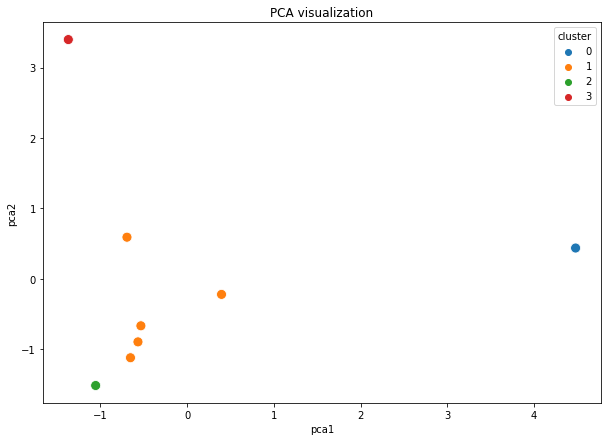

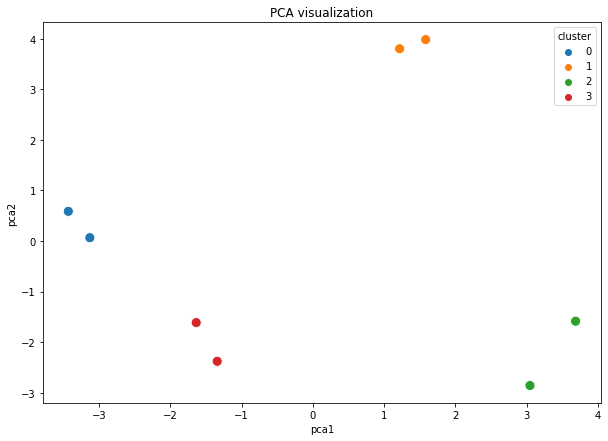

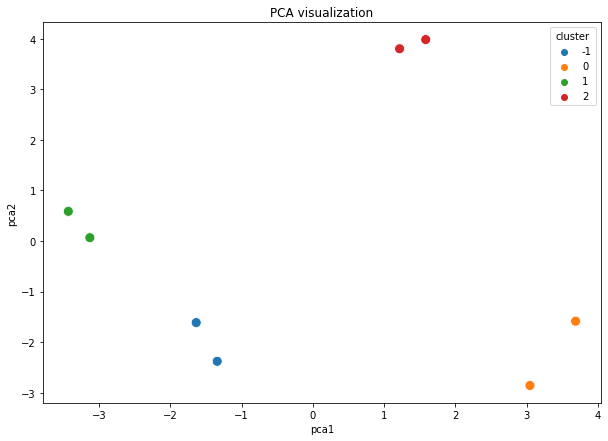

In [11]:
plot_pca_clusters(data=bow_sents, cluster_labels=predictedClustersKBow)
plot_pca_clusters(data=emb_sents, cluster_labels=predictedClustersKEmb)
plot_pca_clusters(data=emb_sents, cluster_labels=predictedClustersDbEmb)

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [12]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:3}

Here is some notation we will be using in this homework. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of non missing ratings in the utility matrix $Y$? 

In [14]:
# Taken from lecture 15
def get_stats(ratings, item_key=item_key, user_key=user_key):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M


N, M = get_stats(ratings)

Number of ratings: 100000
Average rating:  3.530
Number of users (N): 943
Number of items (M): 1682
Fraction non-nan ratings: 0.063


In [15]:
N = 943
M = 1682

1) N = the number of users = 943. M = the number of movies = 1682.
2) Dimensions of utility matrix Y will be: 943 x 1682
3) 
    Since the dimensions are 943 x 1682. The total amount of cells are 943 x 1682 = 1 586 126, but we only have 100 000 ratings.
    Therefore, fraction of non-missing ratings is equal to 100 000 / 1 586 126 = 0.06304 or 6.3%

<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [16]:
# Taken from lecture 15
X = ratings.copy()
y = ratings[user_key]
            
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape

((80000, 4), (20000, 4))

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [17]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
# print(user_mapper)
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
# print(item_mapper)
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
# print(user_inverse_mapper)
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [18]:
# Taken from Lecture 15
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [19]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)
train_mat.shape, valid_mat.shape

((943, 1682), (943, 1682))

Even though the shape of both utility matrices are the same at N x M = 943 x 1682, the validation utility matrix is far more sparse with more NaNs, since X_valid only has 20000 examples while X_train has 80000. 
This is because the data has been split in a way such that we can impute missing ratings on the training matrix, and then compare it to the imputation of missing ratings on the validation set.


<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [20]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

In [21]:
# Taken from Lecture 15

avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
1,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
2,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
3,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
4,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262


In [22]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average rating")

Global average rating train RMSE: 1.13
Global average rating valid RMSE: 1.12


1) We are using the average value  of the training set to determine what rating value should be used for imputation. This RMSE error calculates the difference between the rating value we determined for imputation using the training set compared to the actual rating for examples in the training/validation set.

<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

In [23]:
imputer = KNNImputer(n_neighbors=10)
train_mat_imp = imputer.fit_transform(train_mat)
train_mat_imp_df = pd.DataFrame(train_mat_imp)



# Transform validation matrix since training matrix has columns that can't be imputed
train_mat_df = pd.DataFrame(train_mat)
# These are the columns that are being deleted since they only contain null values and thus cannot be imputed.
columnIdxDel = train_mat_df.columns[train_mat_df.isnull().all()]
    
    
    
    
# Dropping these columns since they are being dropped in the training matrix due to being empty                                    
valid_mat_mod = valid_mat.copy()
valid_mat_mod_df = pd.DataFrame(valid_mat_mod)  

valid_mat_mod_df = valid_mat_mod_df.drop(columns=columnIdxDel)
# valid_mat_mod_df

train_mat_mod = train_mat.copy()
train_mat_mod_df = pd.DataFrame(train_mat_mod)  

train_mat_mod_df = train_mat_mod_df.drop(columns=columnIdxDel)
# train_mat_mod_df




In [24]:
print(pd.DataFrame(train_mat_imp_df))
evaluate(train_mat_imp_df, train_mat_mod_df, valid_mat_mod_df, model_name="KNN imputer")


       0    1    2    3    4    5    6    7    8    9  ...  1643  1644  1645  \
0    4.0  3.0  4.0  3.7  3.0  3.8  4.0  3.3  5.0  3.0  ...  3.0   3.0   1.0    
1    4.0  3.0  3.3  4.1  3.2  4.3  4.4  4.4  4.5  4.1  ...  3.0   3.0   1.0    
2    3.8  3.2  2.8  3.1  3.5  3.5  4.0  3.7  3.7  4.3  ...  3.0   3.0   1.0    
3    4.1  2.9  3.9  3.1  3.6  3.8  3.3  4.3  4.2  4.2  ...  3.0   3.0   1.0    
4    4.0  3.0  3.3  3.8  3.3  4.1  4.0  3.8  3.8  4.1  ...  3.0   3.0   1.0    
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...    
938  3.8  3.7  3.7  3.5  4.0  4.1  4.0  3.9  5.0  4.3  ...  3.0   3.0   1.0    
939  4.1  3.2  3.6  2.0  3.3  3.6  3.7  4.1  3.0  4.3  ...  3.0   3.0   1.0    
940  5.0  3.4  2.9  3.8  3.3  3.6  4.3  3.8  4.5  3.6  ...  3.0   3.0   1.0    
941  4.2  3.4  3.6  3.4  4.0  4.0  3.5  4.3  4.0  4.0  ...  3.0   3.0   1.0    
942  4.3  5.0  3.2  3.6  3.3  4.0  3.7  4.4  3.0  4.1  ...  3.0   3.0   1.0    

     1646  1647  1648  1649  1650  1651

The validation RMSE is slightly better than the base line at 1.02 (an improvement of 1.12-1.02 = 0.10). Looking at the imputed training set, K-NN imputers is uses a more complicated strategy than the baseline, as it doesn't replace every value with the average. It keeps the ratings in the training set for which there were ratings already present and ONLY imputed missing ratings. This is why the training RMSE is significantly better than baseline at 0.50 compared to 1.13.

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [25]:
#Taken from Lecture 15
#Drop unncessary columns in ratings
ratings_copy = ratings.copy()
ratings_copy = ratings_copy.drop(columns="timestamp")

reader = Reader()
data = Dataset.load_from_df(ratings_copy, reader)  # Load the data

trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)


In [26]:
# Taken from Lecture 15
algo = SVD(n_factors=10, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 0.9328


0.932839700199596

The root mean square from SVD is 0.93, where as the RMSE using baseline for validation set is 1.12. 0.93-1.12/1.12 = 0.169 or 16.9% improvement.
Thus, the improvement is not very large over the baseline.

<br><br><br><br>

## Exercise 3: Short answer questions
<hr>

rubric={points:5}

Answer the following short-answer questions: 

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in K-Means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. How might you apply clustering to recommendation systems? 

1) 
    The main difference is that unsupervised learning often tries to find patterns from a unlabelled dataset where as supervised learning has a labelled dataset (containing targets).

2) 
    We don't choose k in order to get the smallest inertia because the smallest intertia is associated with larger and larger values of k. Eventually if the value of k is bigger than the amount of examples in the dataset, every example will be classified as its own cluster by itself, making our model useless in determining patterns through clustering.

3) 
    K-Means is unable to detect outliers and is actually one of its weaknesses since outliers can greatly skew k-mean results, as clustered centers move towards them. This is also because K-Means labels every point in the dataset, it doesn't consider any point as noise/outliers.

4) 
    DBSCAN has two hyperparameters we can tune: eps and min_samples. eps represents the distance between points that we can consider to be close enough to be part of a cluster, where as min_samples represents the minimum amount of points within eps distance that can be considered a cluster. Therefore, to detect outliers, a good strategy would be to use a reasonable value for eps by analyzing the average distance between datapoints like we did in exercise 1.4 using cosine_distances matrix, we do this to avoid using very large values that would consider outliers/noise points as being "close enough". Generally smaller eps values will be better than larger values at finding noise points. As for min_samples, a good strategy is to prefer a larger value over a smaller value, because noise/outliers by definition are not the norm and therefore usually isolated from other normally placed points. By having min_samples have a reasonably large value, we will be able to detect outliers since they won't be close enough to enough points to be considered a cluster.

5) 
    For reccommendation systems where we try to predict ratings by users for movies for example, we can have a plot for every movie, where we have ratings as data points for each user. We can then use a technique such as DBSCAN to cluster the points based on a reasonable eps and min_samples value. Since the goal is ultimately to predict ratings for unseen users, we can try to find the largest cluster and take the average of those scores within to be a logical predictor for the rating of a movie for unseen users.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 